This jupyter notebook contains some of the codes and calculations associated with our recent paper: 

**"The VLT-MUSE and ALMA view of the MACS 1931.8-2635 brightest cluster galaxy"** 

Ciocan B. I. , Ziegler, B. L. , Verdugo, M. , Papaderos, P. , Fogarty, K. , Donahue, M. , and Postman, M.

## Ionisation sources: how to plot BPT diagnostic diagram together with predictions fully radiative shock models

shock model grids:  Alarie et al. (2019)  data-base

In [1]:
import os
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table,join
from astropy.wcs import WCS
import math
from scipy.stats import gaussian_kde


## Loading Data

Load your table with flux measurements for each spaxel of the data cube, as provided by FADO and apply your SNR criterium

In [ ]:
data_dir = "/Users/biancaciocan/Documents/M1931_BCG_PROJECT/M1931_results_FADO_python/"
data_file = "FADO_joned_finito.txt"

table = Table.read(os.path.join(data_dir, data_file),
                   delimiter=" ",format='ascii', guess=False)

SN_Ha = table["SN_Ha"]
SN_Ha_cont_red = table["SN_Ha_cont_red"]
SN_Ha_cont_blue = table["SN_Ha_cont_blue"]

SN_Hb = table["SN_Hb"]
SN_Hb_cont_red = table["SN_Hb_cont_red"]
SN_Hb_cont_blue = table["SN_Hb_cont_blue"]

SN_OIII = table["SN_OIII"]
SN_OIII_cont_red = table["SN_OIII_cont_red"]
SN_OIII_cont_blue = table["SN_OIII_cont_blue"]

SN_NII = table["SN_NII"]
SN_NII_cont_red = table["SN_NII_cont_red"]
SN_NII_cont_blue = table["SN_NII_cont_blue"]


SN_SII_6718=table["SN_SII_6718"]
SN_SII_6718_cont_red=table["SN_SII_6718_cont_red"]
SN_SII_6718_cont_blue=table["SN_SII_6718_cont_blue"]

SN_SII_6732=table["SN_SII_6732"]
SN_SII_6732_cont_red=table["SN_SII_6732_cont_red"]
SN_SII_6732_cont_blue=table["SN_SII_6732_cont_blue"]

SII_flux_6716A=table["175"]
SII_flux_6730A=table["179"]
OIII_flux_5006A= table["111"]
Halpha_flux = table["163"]
Hbeta = table["95"]

# Make S/N cuts
selection =[ (SN_OIII>SN_OIII_cont_blue)&(SN_OIII>SN_OIII_cont_red)&
              (SN_Hb>SN_Hb_cont_red)&(SN_Hb>SN_Hb_cont_blue)&
              (SN_Ha>SN_Ha_cont_blue)&(SN_Ha>SN_Ha_cont_red)&
              (SN_NII>SN_NII_cont_red)& (SN_OIII>10) 
              & (SN_NII>10) & (SN_Ha>10)& (SN_Hb>10) 
              &(SN_SII_6718>10)&(SN_SII_6732>10)
              &(SII_flux_6716A>-99.99)&(SII_flux_6730A>-99.99)
              &(Halpha_flux>-99.99) &(OIII_flux_5006A>-99.99)]

Halpha = table['163'][selection]  
OIII_5006A = table['111'][selection]   
Hbeta = table['95'][selection]   
SII_6716A = table['175'][selection]   
SII_6730A = table['179'][selection]   
NII_6583A = table['167'][selection]  
OI_6300A=table['147'][selection] 


NIIHa = np.log10(  NII_6583A / Halpha ) 
OIIIHb = np.log10( OIII_5006A /  Hbeta )  



## Plot simple BPT diagram:
    

<ipython-input-3-590230c66a6b>:39: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg1 = plt.legend([Kewley, Schwinski, Kaufmann],


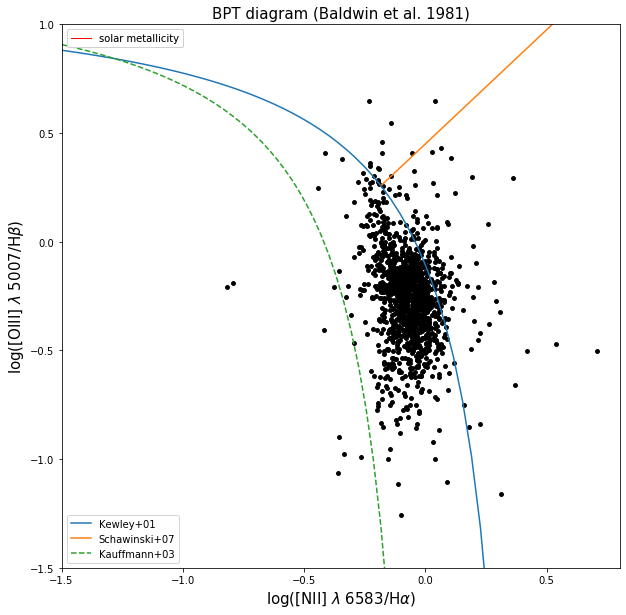

In [3]:
fig, ax = plt.subplots(facecolor='white', figsize=(10,10))


Xmin, Xmax = -1.5, 0.8  
Ymin, Ymax = -1.5, 1  

x = np.linspace(-1.5,0.3)
y = (0.61 / (x  - 0.47  )) + 1.19
 
a = np.linspace(-0.180,1.5)
b = 1.05*a + 0.45

c = np.linspace(-1.5,0.)
d = 0.61 / (c - 0.05) + 1.3


for i in range(1, len(NIIHa)):
    if math.isnan(NIIHa[i]):
        NIIHa[i] = NIIHa[i-1]

for i in range(1, len(OIIIHb)):
    if math.isnan(OIIIHb[i]):
        OIIIHb[i] = OIIIHb[i-1]

xy = np.vstack([NIIHa, OIIIHb])
z = gaussian_kde(xy)(xy)

muse = plt.scatter(NIIHa, OIIIHb, marker='o',s=15,color='black')

Kewley = plt.plot(x,   y, '-'   )  
Schwinski = plt.plot(a, b, '-')  
Kaufmann = plt.plot(c, d, '--')  

plt.xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',  fontsize=15)
plt.ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)', fontsize=15)
plt.title("BPT diagram (Baldwin et al. 1981)", fontsize=15)
plt.ylim(Ymin, Ymax)
plt.xlim(Xmin, Xmax)
leg1 = plt.legend([Kewley, Schwinski, Kaufmann],      
                  labels=['Kewley+01', 'Schawinski+07', 'Kauffmann+03'],    
                  loc="lower left")

plt.gca().add_artist(leg1)

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], ls="-", color="red", lw=1,label="solar metallicity")]

leg2=plt.legend(handles=custom_lines,loc="upper left")
plt.gca().add_artist(leg2)



## Radiative Shock Grids

So now we need to connect to the `3mdb` data base in order to use fully radiative shock grids, it works easy in terminal writing the following:
    
export MdB_HOST='3mdb.astro.unam.mx'<br>
export MdB_USER='OVN_user'<br>
export MdB_PASSWD='oiii5007'<br>
export MdB_PORT='3306'<br>
export MdB_DBs='3MdBs'<br>
export MdB_DBp='3MdB'<br>
export MdB_DB_17='3MdB_17'<br>


You can find the documentation on: https://sites.google.com/site/mexicanmillionmodels/

Or, you can connect to the data base directly in your code as:

In [4]:
host =  '3mdb.astro.unam.mx'
user =   'OVN_user'
passwd =  'oiii5007'
port = '3306'

                                
# Connect to the database
db = pymysql.connect(host=host, user=user, passwd=passwd, port=int(port), db='3MdBs')
                                
#SQL request with pandas
result = pd.read_sql("""SELECT shock_params.shck_vel AS shck_vel, 
                          shock_params.mag_fld AS mag_fld,
                          log10(emis_VI.NII_6583/emis_VI.HI_6563) AS NII6583_Hb,
                          log10(emis_VI.OIII_5007/emis_VI.HI_4861) AS OIII5007_Hb
                          FROM shock_params 
                          INNER JOIN emis_VI ON emis_VI.ModelID=shock_params.ModelID
                          INNER JOIN abundances ON abundances.AbundID=shock_params.AbundID
                          WHERE emis_VI.model_type='shock' 
                          AND abundances.name='Allen2008_Solar'
                          AND shock_params.ref='Allen08'
                          AND shock_params.shck_vel BETWEEN 10 AND 350
                          AND shock_params.preshck_dens=1
                          ORDER BY shck_vel, mag_fld;""", con=db)

plot the BPT diagram with the shock-grids overlaid



<ipython-input-5-58ace5eba83d>:39: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  leg1 = plt.legend([Kewley, Schwinski, Kaufmann],


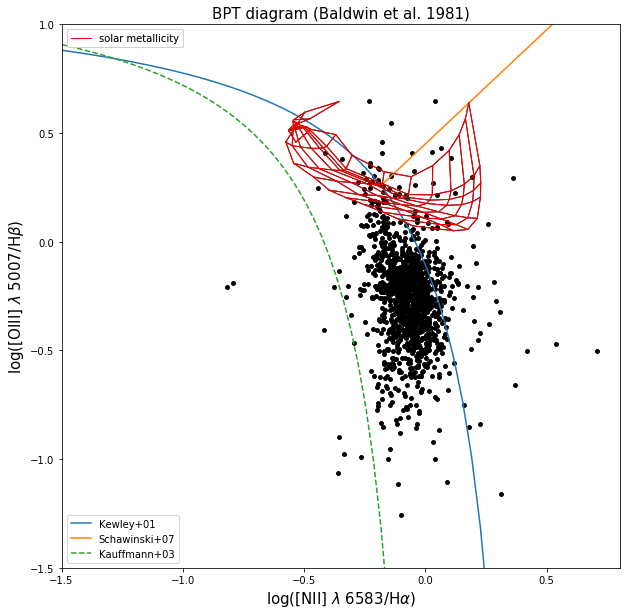

In [5]:
fig, ax = plt.subplots(facecolor='white', figsize=(10,10))


Xmin, Xmax = -1.5, 0.8  
Ymin, Ymax = -1.5, 1  

x = np.linspace(-1.5,0.3)
y = (0.61 / ( x  - 0.47  )) + 1.19
 
a = np.linspace(-0.180,1.5)
b = 1.05*a + 0.45

c = np.linspace(-1.5,0.)
d = 0.61 / (c - 0.05) + 1.3


for i in range(1, len(NIIHa)):
    if math.isnan(NIIHa[i]):
        NIIHa[i] = NIIHa[i-1]

for i in range(1, len(OIIIHb)):
    if math.isnan(OIIIHb[i]):
        OIIIHb[i] = OIIIHb[i-1]

xy = np.vstack([NIIHa, OIIIHb])
z = gaussian_kde(xy)(xy)

muse = plt.scatter(NIIHa, OIIIHb, marker='o',s=15,color='black')

Kewley = plt.plot(x,   y, '-'   )  
Schwinski = plt.plot(a, b, '-')  
Kaufmann = plt.plot(c, d, '--')  

plt.xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',  fontsize=15)
plt.ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)', fontsize=15)
plt.title("BPT diagram (Baldwin et al. 1981)", fontsize=15)
plt.ylim(Ymin, Ymax)
plt.xlim(Xmin, Xmax)
leg1 = plt.legend([Kewley, Schwinski, Kaufmann],      
                  labels=['Kewley+01', 'Schawinski+07', 'Kauffmann+03'],    
                  loc="lower left")

plt.gca().add_artist(leg1)

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], ls="-", color="red", lw=1,label="solar metallicity")]

leg2=plt.legend(handles=custom_lines,loc="upper left")
plt.gca().add_artist(leg2)


for B in np.unique(result.mag_fld):
    idx = np.where(result.mag_fld==B)
    ax.plot(result.NII6583_Hb[idx[0]], result.OIII5007_Hb[idx[0]], color='black', linewidth=1)

for v in np.unique(result.shck_vel):
    idx = np.where(result.shck_vel==v)
    ax.plot(result.NII6583_Hb[idx[0]], result.OIII5007_Hb[idx[0]], color='black', linewidth=1)


from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], ls="-", color="red", lw=1,label="solar metallicity")]

leg2=plt.legend(handles=custom_lines,loc="upper left")
plt.gca().add_artist(leg2)


for B in np.unique(result.mag_fld):
    idx = np.where(result.mag_fld==B)
    ax.plot(result.NII6583_Hb[idx[0]], result.OIII5007_Hb[idx[0]], color='red', linewidth=1)

for v in np.unique(result.shck_vel):
    idx = np.where(result.shck_vel==v)
    ax.plot(result.NII6583_Hb[idx[0]], result.OIII5007_Hb[idx[0]], color='red', linewidth=1)

